In [55]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchinfo import summary
import joblib
import pennylane as qml
torch.manual_seed(42)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [57]:
#Defining quantum layer
n_qubits = 4
n_layers=6
weight_shapes = {"weights": (n_layers, n_qubits)}
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev,interface='torch')
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    exp_val=[qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    return tuple(exp_val)
    #return exp_val
# qml.drawer.use_style("black_white")
# fig,ax=qml.draw_mpl(circuit)([0.26,0.28,3.31,0.85],torch.randn(6,4))
# plt.show()
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
qlayer

<Quantum Torch Layer: func=circuit>

In [58]:
#HYBRID QLSTM Network definition
class NETWORK_HYBRID_QLSTM(nn.Module):

    def __init__(self,num_classes,input_size,hidden_size,num_layers):
        super(NETWORK_HYBRID_QLSTM,self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        # self.hidden_size2 = hidden_size2
        self.lstm1=nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True).to(device)
        # self.lstm2=nn.LSTM(input_size=hidden_size, hidden_size=hidden_size2,
        #                     num_layers=num_layers, batch_first=True).to(device)
        self.fc1=nn.Linear(hidden_size,n_qubits)
        self.qlayer=qlayer
        self.fc2=nn.Linear(n_qubits,num_classes)
    
    def forward(self,x):
        output_lstm1, (h_n,c_n) = self.lstm1(x)
        output_fc1=self.fc1(output_lstm1[:,-1,:])
        input_q=output_fc1
        
        output_q=self.qlayer(input_q)
        output_fc2=self.fc2(output_q).to(device)
        return output_fc2

In [59]:
input_size=4
hidden_size=16
num_layers=2
num_classes=4

model=NETWORK_HYBRID_QLSTM(num_classes,input_size, hidden_size,num_layers)
model.load_state_dict(torch.load('./assets/trainedmodels/hybrid_qlstm_state.pt'))
model.eval()


NETWORK_HYBRID_QLSTM(
  (lstm1): LSTM(4, 16, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=16, out_features=4, bias=True)
  (qlayer): <Quantum Torch Layer: func=circuit>
  (fc2): Linear(in_features=4, out_features=4, bias=True)
)

In [60]:
validation_data=pd.read_csv('./assets/processed dataset/validation dataset.csv')
test_data=pd.read_csv('./assets/processed dataset/test dataset.csv')
train_data=pd.read_csv('./assets/processed dataset/train dataset.csv')
scaler =joblib.load('./assets/scaler.gz')

In [61]:
df1=test_data
input_test=scaler.transform(df1)
input_test[0]

array([0.05265087, 0.51441242, 0.87068004, 0.73206139])

In [62]:
seq_length=180
#Getting x and y for testing
X_test=[]
Y_test=[]

for i in range(seq_length,input_test.shape[0]):
    #Input features from 0 to 59
    X_test.append(input_test[i-seq_length:i])
    #T2M at 60
    Y_test.append(input_test[i])

# converting into numpy arrays
X_test,Y_test=np.array(X_test),np.array(Y_test)
Y_test=Y_test.reshape(-1,4)
print(X_test.shape,Y_test.shape)

X_test = Variable(torch.Tensor(X_test))
Y_test = Variable(torch.Tensor(Y_test))
print(X_test.shape,Y_test.shape)

(2176, 180, 4) (2176, 4)
torch.Size([2176, 180, 4]) torch.Size([2176, 4])


In [63]:
#Testing model
Y_pred=model(X_test.to(device))
Y_pred=Y_pred.detach().numpy()

In [64]:
Y_pred_de=scaler.inverse_transform(Y_pred)
Y_test_de=scaler.inverse_transform(Y_test)

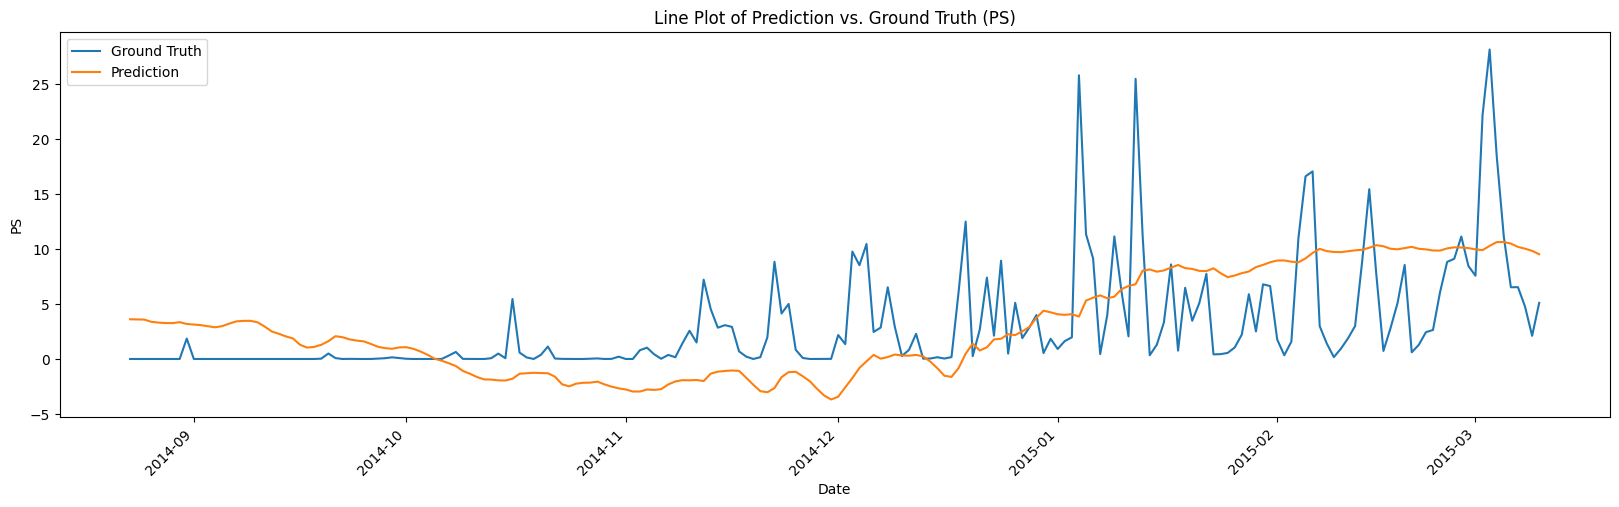

In [69]:
import matplotlib.pyplot as plt
st=0;end=200
date_range= pd.date_range('8/23/2014', '12/31/2019')
# Plot the data
plt.figure(figsize=(20, 5))
plt.plot(date_range[st:end],Y_test_de[st:end,0], label="Ground Truth")
plt.plot(date_range[st:end],Y_pred_de[st:end,0], label="Prediction")

# Set the labels and title
plt.xlabel("Date")
plt.ylabel("PS")
plt.title("Line Plot of Prediction vs. Ground Truth (PS)")

# Add a legend
plt.legend()
plt.xticks(rotation=45, ha='right')
# Show the plot
plt.show()

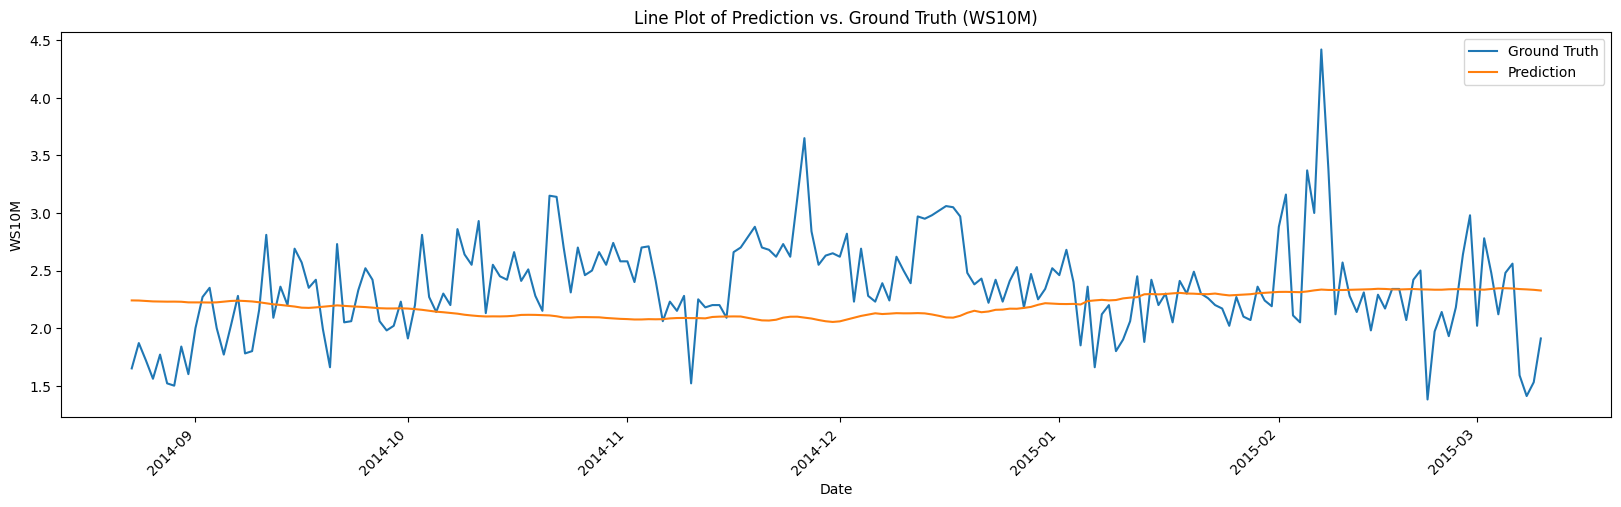

In [66]:
st=0;end=200
date_range = pd.date_range('8/23/2014', '12/31/2019')
# Plot the data
plt.figure(figsize=(20, 5))
plt.plot(date_range[st:end],Y_test_de[st:end,1], label="Ground Truth")
plt.plot(date_range[st:end],Y_pred_de[st:end,1], label="Prediction")

# Set the labels and title
plt.xlabel("Date")
plt.ylabel("WS10M")
plt.title("Line Plot of Prediction vs. Ground Truth (WS10M)")
# Add a legend
plt.legend()
plt.xticks(rotation=45, ha='right')
# Show the plot
plt.show()

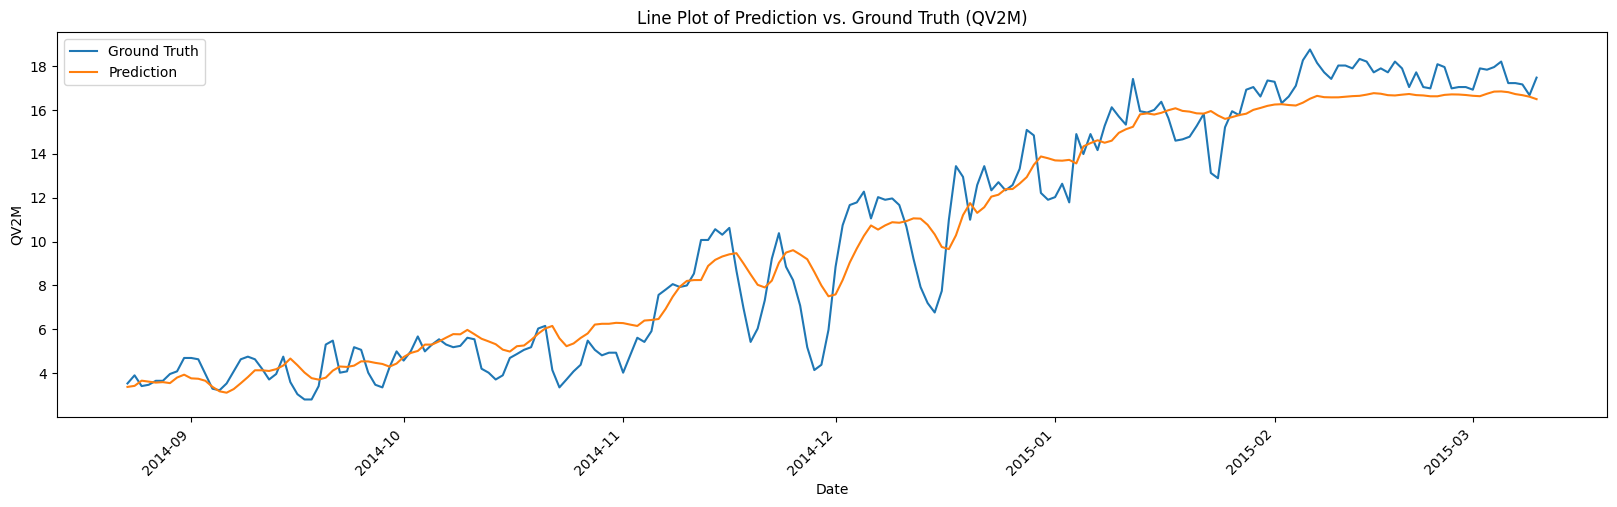

In [67]:
import matplotlib.pyplot as plt
st=0;end=200
date_range = pd.date_range('8/23/2014', '12/31/2019')
# Plot the data
plt.figure(figsize=(20, 5))
plt.plot(date_range[st:end],Y_test_de[st:end,2], label="Ground Truth")
plt.plot(date_range[st:end],Y_pred_de[st:end,2], label="Prediction")

# Set the labels and title
plt.xlabel("Date")
plt.ylabel("QV2M")
plt.title("Line Plot of Prediction vs. Ground Truth (QV2M)")

# Add a legend
plt.legend()
plt.xticks(rotation=45, ha='right')
# Show the plot
plt.show()

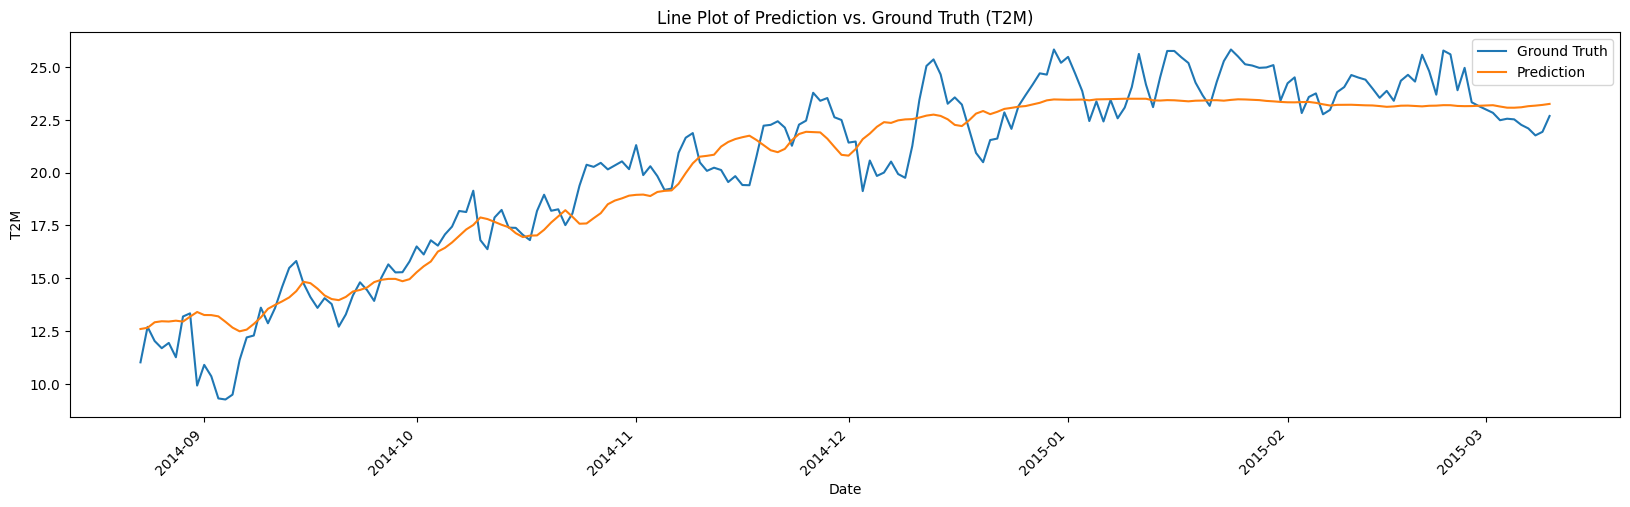

In [68]:
import matplotlib.pyplot as plt
st=0;end=200
date_range = pd.date_range('8/23/2014', '12/31/2019')
# Plot the data
plt.figure(figsize=(20, 5))
plt.plot(date_range[st:end],Y_test_de[st:end,3], label="Ground Truth")
plt.plot(date_range[st:end],Y_pred_de[st:end,3], label="Prediction")

# Set the labels and title
plt.xlabel("Date")
plt.ylabel("T2M")
plt.title("Line Plot of Prediction vs. Ground Truth (T2M)")

# Add a legend
plt.legend()
plt.xticks(rotation=45, ha='right')
# Show the plot
plt.show()